In [1]:
import os
import glob
import random

import torch
import torchvision
import numpy as np
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

from IPython.display import Image

Подключаем cuda

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

## Датасет

Ссылка на датасет - https://www.kaggle.com/datasets/lantian773030/pokemonclassification

Датасет состоит из изображений покемонов, разделенных на классы.

Всего 150 классов.

Изображения изначально разных размеров, приведем изображения к одному размеру 100 на 100 пикселей

In [3]:
import os
import glob
import matplotlib.pyplot as plt

In [4]:
DATA_PATH = r'D:\ProgrammingPython\neural_networks\PokemonData_200'
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

class PokemonDataset(Dataset):
    
    def __init__(self, rootdir, transform=None) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)
            
    def __len__(self):
        return len(self.images_pathes)
    
    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)
        
        if self.transform:
           image = self.transform(image=image)["image"]

        return (image, label)

In [5]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label
        
    def __len__(self):
        return len(self.subset)

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# попробовать флипы
# попробовать аффинные преобразония
# с цветовыми аугментациями не баловаться
# кропы (аккуратно)
# шумы

album_transform = A.Compose([
    A.HorizontalFlip(p=0.15),
    A.ElasticTransform(alpha=1.15, sigma=15, alpha_affine=25),
    A.GaussNoise(p=0.25),
    #A.RandomBrightnessContrast(p=0.4),
    A.Blur(blur_limit=1),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize(mean = 0.5, std = 0.5)
    ]
)

simple_transform = A.Compose([
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

In [7]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

Оригинальный датасет не разделен на тренировочную и тестовую выборки, поэтому разделим датасет в соотношении 80 на 20

In [8]:
TEST_SIZE = 0.2
BATCH_SIZE = 32
SEED = 42

In [9]:
dataset = PokemonDataset(DATA_PATH)

In [10]:
generator = torch.Generator().manual_seed(SEED)

train_dataset, test_dataset = random_split(dataset, [1-TEST_SIZE, TEST_SIZE], generator=generator)

In [11]:
train_modified_dataset = TransformDataset(train_dataset, album_transform)
test_modified_dataset = TransformDataset(test_dataset, simple_transform)

In [12]:
train_loader = DataLoader(train_modified_dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(test_modified_dataset, batch_size=BATCH_SIZE)

In [13]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break


torch.Size([32, 3, 200, 200])
tensor([ 30,  68,  91, 102,  59, 117,  42,  31,  74, 129,  65,  78, 105,  47,
         76,  45,  66,   1, 132,  64,   0,  63, 122,  60,  14,  64, 108, 112,
         52,  48, 110,  35])


In [14]:
def plot_imgs(data_loader):
    plt.rcParams.update({'font.size': 10})
    fig = plt.figure(figsize=(5, 5))
    columns = 2
    rows = 2
    for i in range(columns*rows):
        for x, y in data_loader:
            img = (x[i].numpy().transpose(1, 2, 0) + 1) / 2
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #plt.figure(figsize=(6, 6))
            #plt.axis('off')
            a = fig.add_subplot(rows, columns, i+1)
            plt.axis('off')
            plt.imshow((img*255).astype('int32'))
            a.set_title(classes[int(y[i])])
            #plt.title(classes[int(y[i])])
            break
    plt.show()

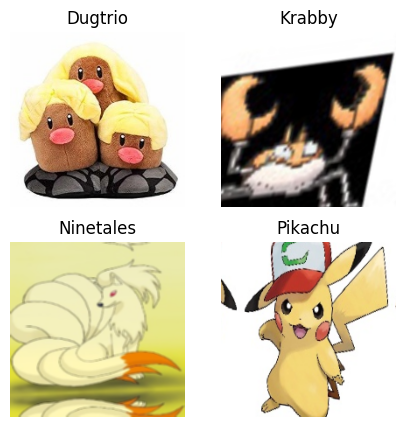

In [15]:
plot_imgs(train_loader)

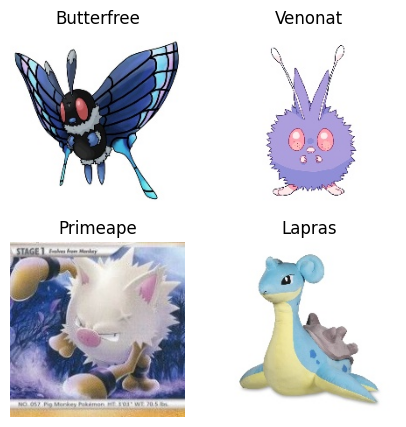

In [16]:
plot_imgs(test_loader)

## Модель ResNet50

In [17]:
# выход с последнего слоя
print(f"Кол-во классов: {len(classes.values())}")

Кол-во классов: 150


In [20]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)

Посмотрим на последний слой модели

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Изменим последний слой под свою задачу

In [22]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=150
    ),
)

In [23]:
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.0001,)

In [24]:
import tqdm

In [25]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)
    
    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    acc = 0
    loss = 0
    for ep in range(epoch):
        print("epoch: ", ep+1)
        for step, (x, y) in enumerate(dataloader):
            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*BATCH_SIZE
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, test_loader)
        #print(f"loss = {loss}")
        print('accuracy =', acc)

        #torch.save(model, f'pokemon_classifier_{epoch}_{acc}.pt')

    return acc


In [26]:
accuracy = train(train_loader, model, loss_function, optimizator, 4)

epoch:  1


d:\ProgrammingPython\neural_networks\.conda\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


loss = 5.055047988891602, samples = 32
loss = 3.1816518306732178, samples = 3232
accuracy = 0.772351615326822
epoch:  2
loss = 1.1051156520843506, samples = 64
loss = 0.27767544984817505, samples = 6464
accuracy = 0.8745304282494365
epoch:  3
loss = 0.4293873608112335, samples = 96
loss = 0.22150130569934845, samples = 9696
accuracy = 0.8895567242674681
epoch:  4
loss = 0.06549803167581558, samples = 128
loss = 0.06887511909008026, samples = 12928
accuracy = 0.9218632607062359


Сохраним модель, указав датасет, кол-во эпох и точность

In [27]:
accuracy = (accuracy*100)
output_str = f"pokemon_200_resnet50_classifier_4_{accuracy:.2f}"
output_str = output_str.replace(".", "_")
output_str = output_str + '.pt'
print(output_str)

pokemon_200_resnet50_classifier_5_92_19.pt


In [28]:
torch.save(model, output_str)

## Оценка модели

In [29]:
model.to('cpu')
model(x).size()

torch.Size([32, 150])

In [30]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to('cpu')), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))


42


Посмотрим ответы модели

С помощью num_in_batch выбираем картинку в первом batch

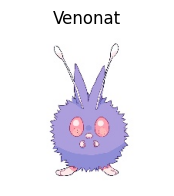

Истинная метка: 137 - Venonat
Предсказ метка: 137 - Venonat


In [32]:
num_in_batch = 1
for x,y in test_loader:
    # Преобразование значений изображения из диапазона [-1, 1] в диапазон [0, 1]
    img = (x[num_in_batch].numpy().transpose(1, 2, 0) + 1) / 2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    # Преобразование значений изображения из диапазона [0, 1] в диапазон [0, 255] (Перемешались цвет. каналы)
    plt.imshow((img*255).astype('int32'))
    plt.title(classes[int(y[num_in_batch])])
    plt.show()
    print(f'Истинная метка: {y[num_in_batch].numpy()} - {classes[int(y[num_in_batch])]}')
    print(f'Предсказ метка: {predicts[0][num_in_batch]} - {classes[int(predicts[0][num_in_batch])]}')
    break

In [33]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

Посчитаем метрики: Accuracy, Precision, recall. Посчитаем для каждого класса в бинарном виде каждую метрику и возьмём среднее.

In [35]:
print(f"Accuracy = {accuracy_score(labels, predicts)}",
    f"\nPrecision = {precision_score(labels, predicts, average=None, zero_division=0).mean()}",
    f"\nRecall = {recall_score(labels, predicts, average=None).mean()}")

Accuracy = 0.9218632607062359 
Precision = 0.9201682576682577 
Recall = 0.9134942776521723


In [36]:
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))

In [37]:
cm.shape

(150, 150)

In [38]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          font_size = 14):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(60, 40))
    plt.rcParams.update({'font.size': font_size})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

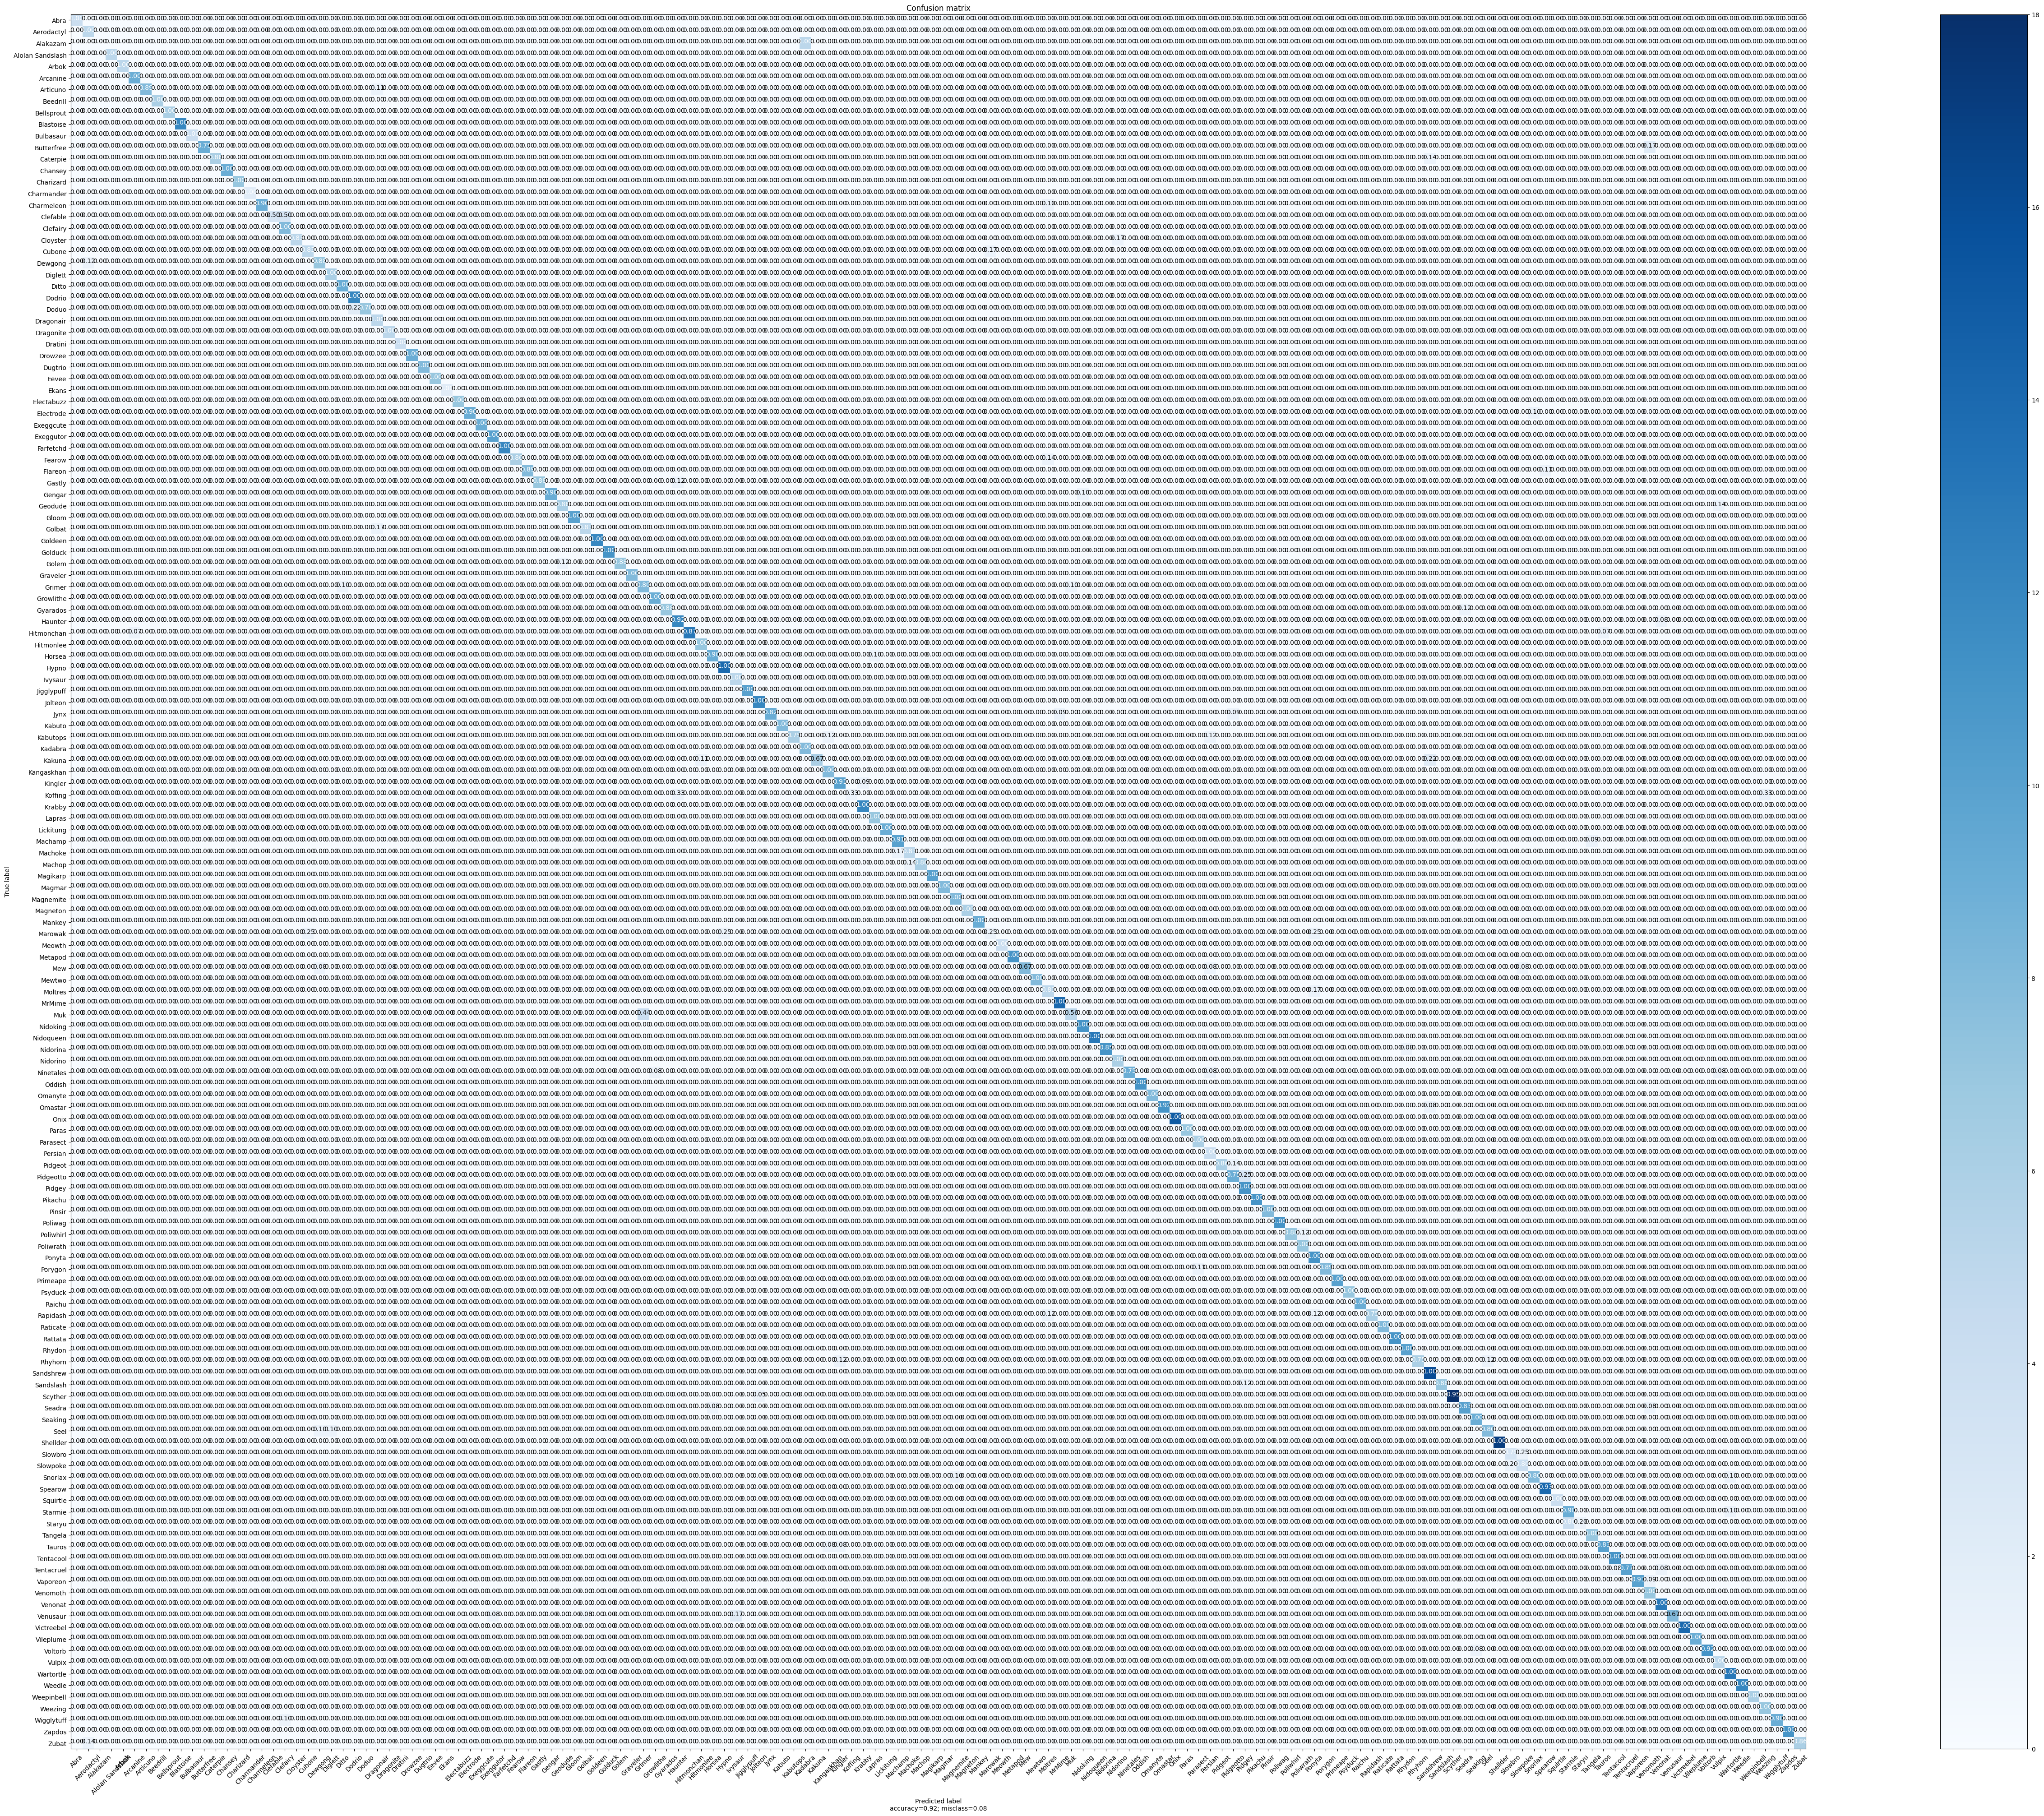

In [39]:
plot_confusion_matrix(cm, tuple(classes.values()), font_size=10)

C:\Users\Professional\AppData\Local\Temp\ipykernel_13124\3821416726.py:60: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


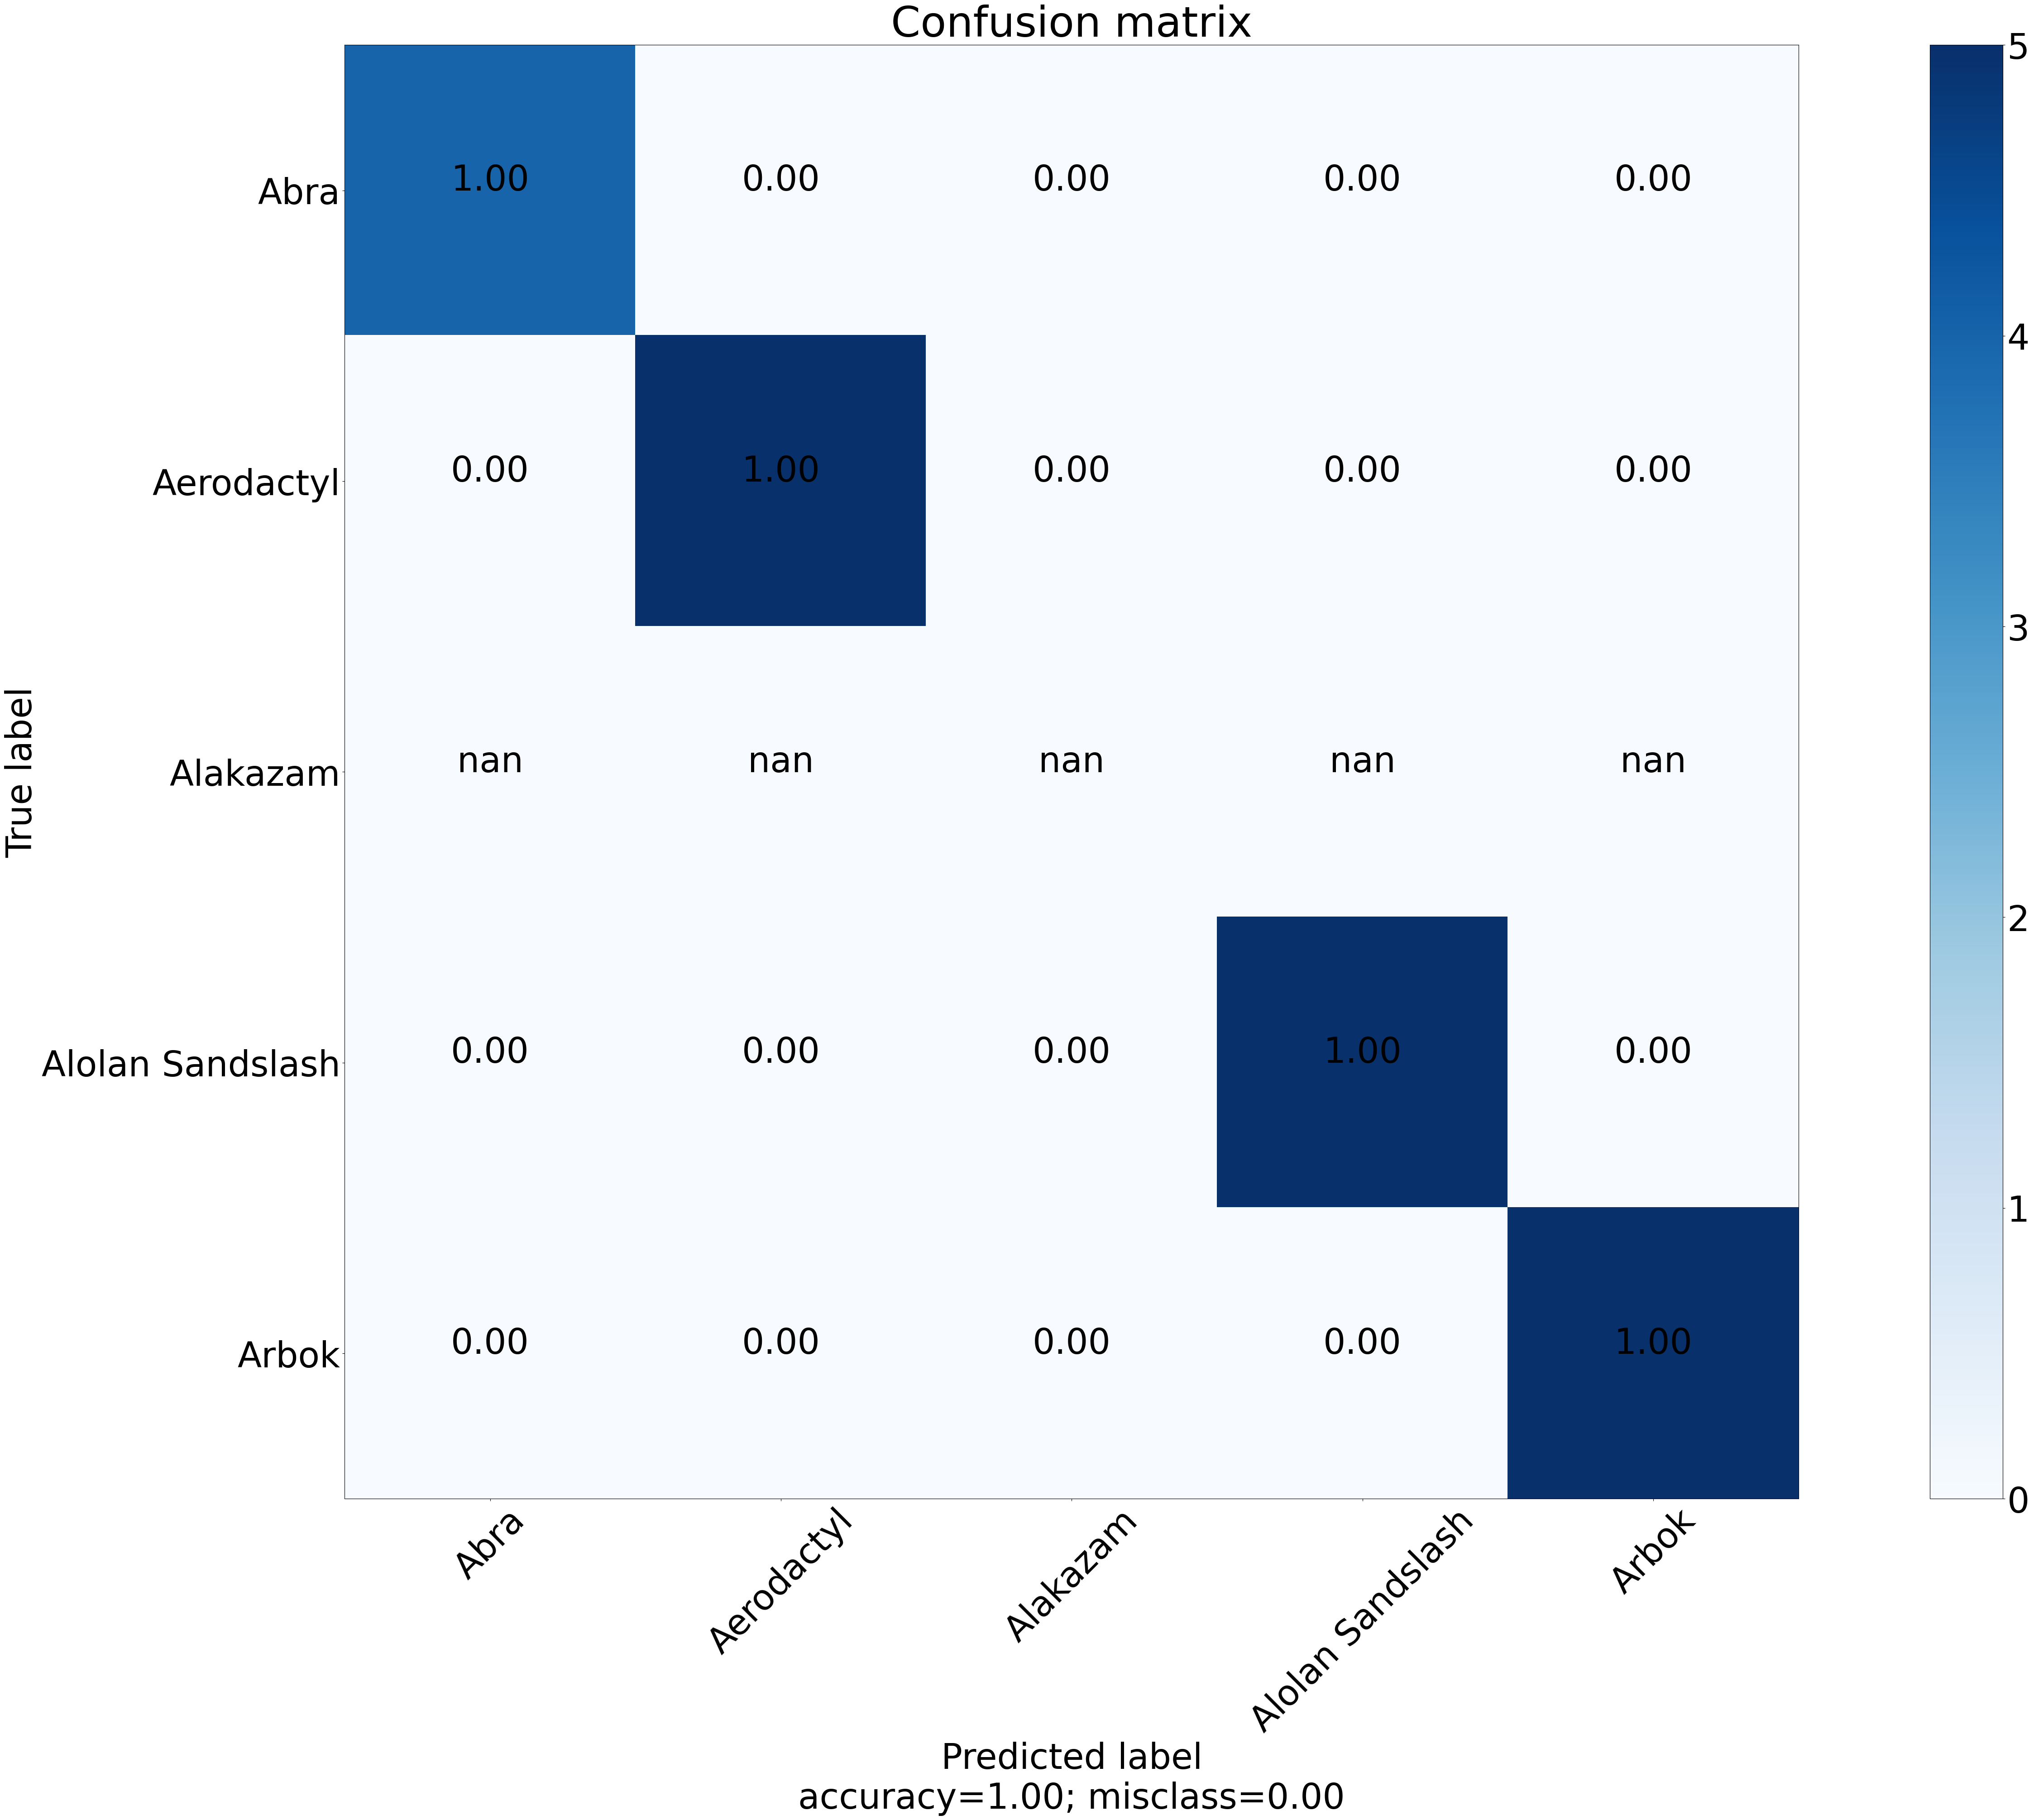

In [40]:
plot_confusion_matrix(cm[:5,:5], tuple(classes.values())[:5], font_size=56)